Behavior Engineering Competition
--

---

The Choice Engineering Competition is an academic competition that invites participants to devise mechanisms that engineer behavior. 

This Notebook  details the structure of the competition's sample data, instructions on how to import the data and examples for some basic analysis. 

For more details on the competition, see the [competition's website](http://decision-making-lab.com/competition/index.html).

>>[Behavior Engineering Competition](#scrollTo=nSJMwMg9CrV1)

>[Import Data](#scrollTo=7ObrGM9SS2HJ)

>>[Data files organization](#scrollTo=NU8v6KWSlWhc)

>>[Import data on the fly](#scrollTo=zTr2AKVsqEse)

>>>[Get URLs of all data files](#scrollTo=zTr2AKVsqEse)

>>>[CSV file structure](#scrollTo=-Z90s750tuwE)

>>>[Read and parse all data files](#scrollTo=u5_FYWawqS8X)

>[Analyse data](#scrollTo=DSdc0ZJzHbtT)

>>[Exclude subjects without complete data](#scrollTo=4QlcRk3KLYrg)

>>[Effects of yes\no reward on next trial's choice](#scrollTo=JRrIfH4zLxMz)

>>>[Distribution of rewards per game, across subjects](#scrollTo=LXwyAAS9ZUp2)

>>>[Effect of reward on next choice](#scrollTo=hGJCauiaZpzi)

>>>[Effect of NO reward on next choice](#scrollTo=Vz2sZKOwkLT-)

>>>[Per subject Δp distribution](#scrollTo=e89vjECe8SRA)

>>[Bias distribution](#scrollTo=uQ9CA7XKlxZj)



#Import Data 
The competition data is found in [the competition's GitHub repository](https://github.com/ohaddan/competition), under the [data folder](https://github.com/ohaddan/competition/tree/master/data). 

The whole repository could be [downloaded as zip](https://github.com/ohaddan/competition/archive/master.zip), or cloned by running the folllowing in your GIT terminal:

>`git clone https://github.com/ohaddan/competition.git`

Alternatively, data could be fetched on-the-fly,  using [GitHub's REST API](https://developer.github.com/v3/), or  as demonstrated below,  directly from the competition's website.

##Data files organization
All data is found under the  [data directory](https://github.com/ohaddan/competition/tree/master/data), each of its sub-directories contain results from a specific allocation protocol. Each of the model directories holds CSV files, each representing the experimental behavior of a single subject.



---



├── data


│┉┉├── model_0

│┉┉┉┉├── *user_id_0*.csv

│┉┉┉┉└── *user_id_1*.csv

│┉┉┉┉└──   ...

│┉┉└── model_1

│┉┉┉┉├── *user_id_0*.csv

│┉┉┉┉└── *user_id_1*.csv

│┉┉┉┉└──   ...





##Import data on the fly
### Get URLs of all data files

[This link](http://decision-making-lab.com/visual_experiment/cmptn_remote/api/get_all_sequnces.php) returns the URLs of all CSV filesholding subjects data. 

The URLs are in the following structure: 

    BASE_URL/is_staic/model_name/user_id.csv
    
  Where:
  

1.  **is_staic**: gets ones of the values {*STATIC*, *DYNAMIC*}, representing whether the model is static or dynamic (see [competition description](http://decision-making-lab.com/competition/Submit.html)).
2.  ** model_name**: is the name of the model used for reward allocation.
3. **user_id**: is an identifier of the specific user whose results in current file.


    

In [0]:
import requests
import json

STATIC = 'STATIC'
DYNAMIC = 'DYNAMIC'
URLS = "URLs"

def parse_url(url):
  split_url = url.split('/')
  
  csv_name = split_url[-1]  
  model_name = split_url[-2]
  is_static = STATIC if (split_url[-3] == STATIC) else DYNAMIC
  return is_static, model_name, csv_name

GET_CSV_LIST_URL = 'http://decision-making-lab.com/visual_experiment/cmptn_remote/api/get_all_sequnces.php'
csv_url_list = requests.get(GET_CSV_LIST_URL)
csv_urls = json.loads(csv_url_list.content)
urls = {STATIC: {}, DYNAMIC: {}};
for url in csv_urls:
  is_static, model_name, csv_name = parse_url(url)
  if 'csv' in url:
      if model_name not in urls[is_static]:
        urls[is_static][model_name] = {}
        urls[is_static][model_name][URLS] = set()
      urls[is_static][model_name][URLS].add(url)

###CSV file structure


**Example**:

| trial_number | time                  | schedule_type | schedule_name | is_biased_choice | side_choice | Reaction time | observed_reward | unobserved_reward | biased_reward | unbiased_reward |
|--------------|-----------------------|---------------|---------------|------------------|-------------|---------------|-----------------|-------------------|---------------|-----------------|
| 0            | 2018-07-29 03:46:24pm | STATIC        | random_0      | false            | LEFT        | 5874          | 1               | 0                 | 0             | 1               |
| 1            | 2018-07-29 03:46:27pm | STATIC        | random_0      | false            | LEFT        | 3021          | 1               | 1                 | 1             | 1               |
| 2            | 2018-07-29 03:46:31pm | STATIC        | random_0      | true             | RIGHT       | 3250          | 0               | 1                 | 1             | 0               |

###Read and parse all data files

### Extract batch number
Data was run in multiple batches, extract from trials' time to which batch do current user belong

In [0]:
from dateutil import parser

FIRST_BATCH_END_TIME = parser.parse('2018-07-29 04:30:00pm')
SECOND_BATCH_END_TIME = parser.parse('2018-08-15 02:30:00pm')
THIRD_BATCH_END_TIME = parser.parse('2018-08-15 05:30:00pm')


def get_batch_num(trial_time):
  '''
  Return 1 for batch 1 - games run before: 2018-07-29 04:30:00pm
  Return 2 for batch 2 - games run after : 2018-08-29 04:30:00pm
                               and before: 2018-08-15 02:30:08pm	
  Return 3 for batch 3 - games run after : 2018-08-15 02:30:08pm		
                               
  '''
  trial_time = parser.parse(trial_time)
  if trial_time < FIRST_BATCH_END_TIME : # greater than:=later than
    return 1
  elif  FIRST_BATCH_END_TIME < trial_time < SECOND_BATCH_END_TIME:
    return 2
  elif  SECOND_BATCH_END_TIME < trial_time < THIRD_BATCH_END_TIME:
    return 3


In [0]:
import csv
import pandas as pd

USERS = 'users'
is_static = STATIC
users_data = {}
users_data[is_static] = {}

for model in urls[is_static].keys():
  if model not in users_data.keys():
    users_data[is_static][model] = {}
    users_data[is_static][model][USERS] = []
  current_model_urls = urls[is_static][model][URLS]
  for current_model_url in current_model_urls:
    data_frame = pd.read_csv(current_model_url)
    (num_cols, num_rows) = data_frame.shape
    num_trials = num_cols + 1
    current_user = {}
    current_user['is_biased_choice'] = data_frame[' is_biased_choice']
    current_user['observed_reward'] = data_frame[' observed_reward']
    current_user['schedule_name'] = data_frame[' schedule_name']
    current_user['side_choice'] = data_frame[' side_choice']
    user_time = data_frame[' time']
    current_user['batch'] = get_batch_num(user_time[0])
    users_data[is_static][model][USERS].append(current_user)


#Analyse data


## Exclude subjects without complete data

In [19]:
MIN_TRIALS_FOR_VALID_USER = 95

all_users = []
for model in users_data[is_static].keys():
  all_users.extend(users_data[is_static][model][USERS])

completed_users = [user for user in all_users if 
                   user['is_biased_choice'].size > MIN_TRIALS_FOR_VALID_USER]
# completed_users = [user for user in all_users if 
#                    (user['batch']==1)
#                    and
#                    (user['is_biased_choice'].size > MIN_TRIALS_FOR_VALID_USER)]
#!!!REMOVE!!!
number_of_completed_users = len(completed_users)
print('Number of completed users:', number_of_completed_users)
  

Number of completed users: 391


##Effects of yes\no reward on next trial's choice

In [0]:
REWARD = 1
NO_REWARD = 0
number_of_rewards = []
is_same_chioce_after_reward_all_users = []
is_switch_after_no_reward_all_users = []

for user in completed_users:
  rewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == REWARD]
  
  number_of_rewards.append(len(rewarded_trials_indices))
  
  is_same_chioce_after_reward = [
      user['is_biased_choice'][reward_index]==
      user['is_biased_choice'][reward_index+1] 
      for reward_index in rewarded_trials_indices
      if reward_index < (len(user['is_biased_choice'])-2)]
  is_same_chioce_after_reward_all_users.append(is_same_chioce_after_reward)

  unrewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == NO_REWARD]
  is_switch_after_no_reward = [
      user['is_biased_choice'][no_reward_index]!=
      user['is_biased_choice'][no_reward_index+1] 
      for no_reward_index in unrewarded_trials_indices
      if no_reward_index < (len(user['is_biased_choice'])-2)]
  is_switch_after_no_reward_all_users.append(is_switch_after_no_reward)




### Distribution of rewards per game, across subjects

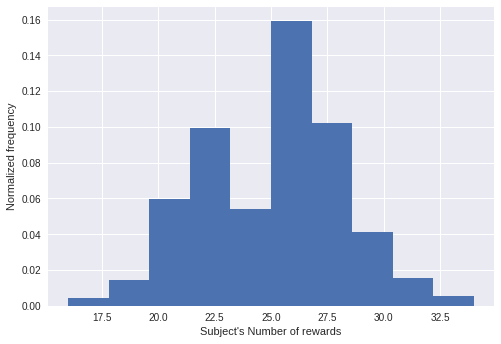

In [21]:
import matplotlib.pyplot as plt

plt.hist(number_of_rewards, normed=True, bins=10)
plt.ylabel('Normalized frequency');
plt.xlabel("Subject's Number of rewards");
plt.title(str(len(number_of_rewards)) + " users - rewards per subject distribution")

###Effect of reward on next choice

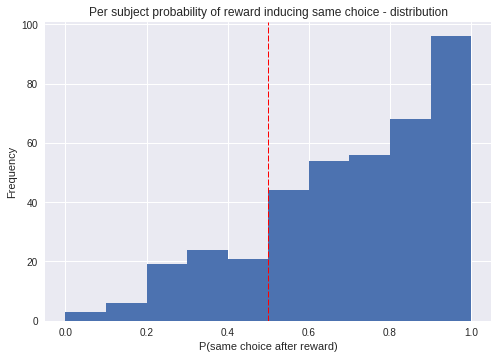

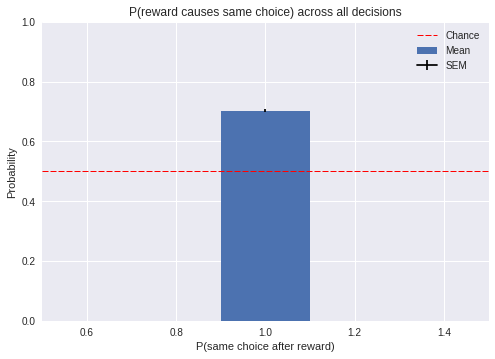

In [22]:
import numpy as np
from scipy import stats

is_same_chioce_after_reward_each_user_average = [
  np.mean(user_is_same_choice) 
  for user_is_same_choice in is_same_chioce_after_reward_all_users]

# Probability per subject (distribution)
plt.ylabel('Frequency');
plt.xlabel('P(same choice after reward)');
plt.axvline(x=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.title('Per subject probability of reward inducing same choice - distribution')
plt.hist(is_same_chioce_after_reward_each_user_average, bins=10)


# Probability across all subjects (mean)
plt.figure()
all_users_choices = [is_same_choice 
             for user in is_same_chioce_after_reward_all_users 
             for is_same_choice in user]
plt.bar(1, np.mean(all_users_choices), width=0.2)
plt.errorbar(1, np.mean(all_users_choices), stats.sem(all_users_choices), color="black")
plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.xlim(.5,1.5)
plt.ylim(0,1)
plt.legend(['Chance','Mean','SEM'])
plt.title('P(reward causes same choice) across all decisions')
plt.ylabel('Probability');
plt.xlabel('P(same choice after reward)');



###Effect of NO reward on next choice

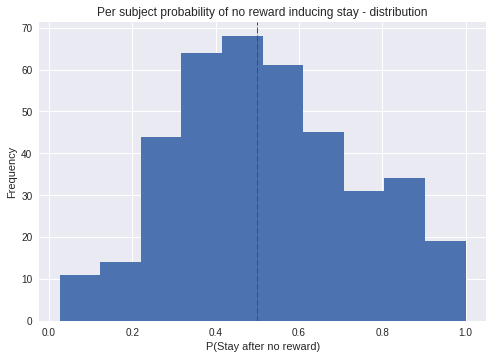

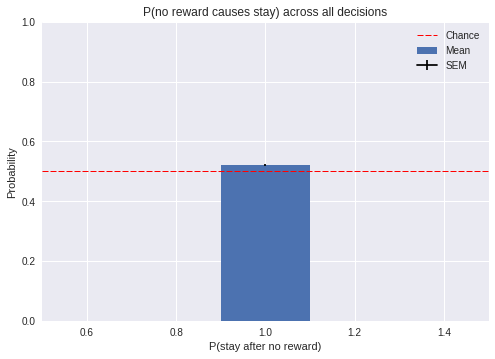

In [23]:
PLOT_IS_SWITCH_AFTER_NO_REWARD = False # if false, plot is *stay* after no reward

is_switch_after_no_reward_each_user_average = [
  np.mean(user_is_switch) 
  for user_is_switch in is_switch_after_no_reward_all_users]

is_stay_after_no_reward_each_user_average = [
  1-np.mean(user_is_switch) 
  for user_is_switch in is_switch_after_no_reward_all_users]


# Probability per subject (distribution)
if PLOT_IS_SWITCH_AFTER_NO_REWARD:
  plt.hist(is_switch_after_no_reward_each_user_average, bins=10)
  plt.title('Per subject probability of no reward inducing switch - distribution')
  plt.xlabel('P(Switch after no reward)');

else:
  plt.hist(is_stay_after_no_reward_each_user_average, bins=10)
  plt.title('Per subject probability of no reward inducing stay - distribution')
  plt.xlabel('P(Stay after no reward)');

plt.ylabel('Frequency');
plt.axvline(x=0.5,linewidth=1, color='r', dashes=[6, 2])


# Probability across all subjects (mean)
plt.figure()
all_users_is_switch = [is_switch 
             for user in is_switch_after_no_reward_all_users 
             for is_switch in user]

all_users_is_stay_after_no_reward = [not is_switch
             for user in is_switch_after_no_reward_all_users 
             for is_switch in user]
if PLOT_IS_SWITCH_AFTER_NO_REWARD:
  plt.bar(1, np.mean(all_users_is_switch), width=0.2)
  plt.errorbar(1, np.mean(all_users_is_switch), 
               stats.sem(all_users_is_switch), color="black")
  plt.title('P(no reward causes switch) across all decisions')
  plt.xlabel('P(switch after no reward)');

else:
  plt.bar(1, np.mean(all_users_is_stay_after_no_reward), width=0.2)
  plt.errorbar(1, np.mean(all_users_is_stay_after_no_reward), 
               stats.sem(all_users_is_stay_after_no_reward), color="black")
  plt.title('P(no reward causes stay) across all decisions')
  plt.xlabel('P(stay after no reward)');


plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.xlim(.5,1.5)
plt.ylim(0,1)
plt.legend(['Chance','Mean','SEM'])
plt.ylabel('Probability');



Number of decision: 38171
Outcome causes same sequential choice (REWARD-NO_REWARD): 18.07 %
Ttest difference between(stay after rewards, stay after NO reward) Ttest_indResult(statistic=38.94168322121604, pvalue=0.0)


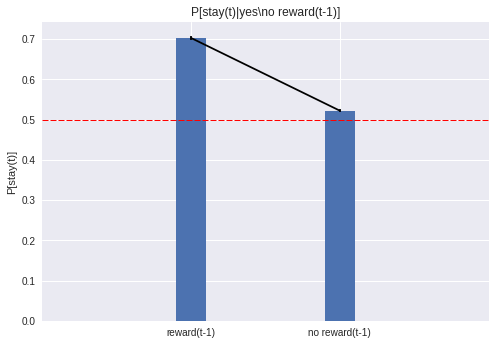

In [50]:
print('Number of decision:', len(all_users_choices) + len(all_users_is_stay_after_no_reward))
mean_after_reward = np.mean(all_users_choices)
sem_after_reward = stats.sem(all_users_choices)
mean_after_no_reward = np.mean(all_users_is_stay_after_no_reward)
sem_after_no_reward = stats.sem(all_users_is_stay_after_no_reward)


plt.bar([1, 2], [mean_after_reward, mean_after_no_reward], width=0.2)
plt.errorbar([1, 2], [mean_after_reward, mean_after_no_reward],
             [sem_after_reward, sem_after_no_reward], color="black")
plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])

plt.title('P[stay(t)|yes\\no reward(t-1)]')
plt.ylabel('P[stay(t)]');
plt.xticks([1, 2], ['reward(t-1)', 'no reward(t-1)'])
  
percentage_behavioral_change = 100*(np.mean(all_users_choices) - (1-np.mean(all_users_is_switch)))
print('Outcome causes same sequential choice (REWARD-NO_REWARD):', round(percentage_behavioral_change,2), '%')
plt.xlim(0,3)

print("Ttest difference between(stay after rewards, stay after NO reward)"
      ,stats.ttest_ind(all_users_choices,  all_users_is_switch))


###Per subject Δp distribution
For each subject, calcualte: 

    P(stay(t)|reward(t-1))-P(stay(t)|NO_reward(t-1))

Text(0.5,1,'Per subject Δp distribution')

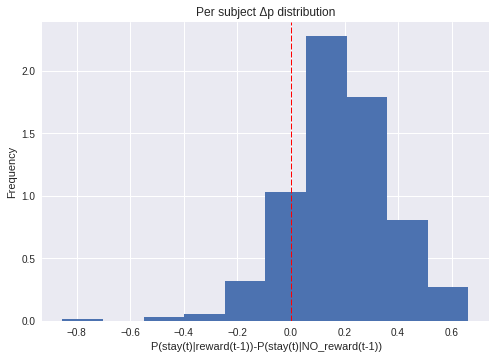

In [27]:
delta_p = []

number_of_rewardewd_trials = []
number_of_unrewardewd_trials = []

for user in completed_users:
  rewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == REWARD]
  
  is_same_chioce_after_reward = [
      user['is_biased_choice'][reward_index]==
      user['is_biased_choice'][reward_index+1] 
      for reward_index in rewarded_trials_indices
      if reward_index < (len(user['is_biased_choice'])-2)]
  p_stay_after_reward = np.mean(is_same_chioce_after_reward)
  number_of_rewardewd_trials.append(len(is_same_chioce_after_reward))
  
  unrewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == NO_REWARD]
  is_same_chioce_after_NO_reward = [
      user['is_biased_choice'][un_reward_index]==
      user['is_biased_choice'][un_reward_index+1] 
      for un_reward_index in unrewarded_trials_indices
      if un_reward_index < (len(user['is_biased_choice'])-2)]
  p_stay_after_NO_reward = np.mean(is_same_chioce_after_NO_reward)
  number_of_unrewardewd_trials.append(len(is_same_chioce_after_NO_reward))
  
  user_delta_p = p_stay_after_reward - p_stay_after_NO_reward
  delta_p.append(user_delta_p)
  
# print('number_of_rewardewd_trials:', number_of_rewardewd_trials)
# print('number_of_unrewardewd_trials:', number_of_unrewardewd_trials)
  
plt.hist(delta_p, normed=True, bins=10)
plt.ylabel('Frequency')
plt.xlabel(" P(stay(t)|reward(t-1))-P(stay(t)|NO_reward(t-1))")
plt.axvline(x=0,linewidth=1, color='r', dashes=[6, 2])
plt.title('Per subject Δp distribution')


#### Seperate analysis by batch
For each batch, for all subjects calcualte: 

    P(stay(t)|reward(t-1))-P(stay(t)|NO_reward(t-1))

number_of_rewardewd_trials: {1: [25, 21, 21, 25, 24, 28, 23, 16, 22, 25, 22, 25, 26, 25, 26, 33, 24, 24, 21, 19, 23, 27, 25, 28, 21, 22, 26, 26, 24, 23, 26, 23, 25, 26, 22, 29, 22, 21, 23, 26, 23, 25, 19, 25, 26], 2: [23, 29, 28, 24, 31, 26, 23, 24, 25, 28, 24, 25, 28, 26, 23, 28, 25, 27, 27, 26, 25, 26, 23, 29, 26, 25, 22, 26, 26, 20, 29, 23, 26, 22, 26, 23, 23, 26, 22, 22, 22, 18, 23, 25, 25, 20, 20, 20, 21, 26, 28, 26, 26, 26, 23, 22, 28, 25, 27, 27, 21, 26, 27, 19, 28, 23, 27, 27, 25, 28, 17, 18, 26, 25, 23, 25, 23, 26, 28, 24, 25, 20, 22, 23, 31, 23, 27, 21, 22, 22, 22, 25, 21, 25, 27, 24, 31, 20, 31, 28], 3: [27, 25, 25, 22, 26, 25, 25, 25, 25, 24, 23, 19, 34, 28, 30, 21, 25, 25, 31, 22, 26, 23, 30, 28, 25, 22, 19, 25, 20, 23, 20, 22, 23, 25, 26, 26, 24, 27, 23, 30, 25, 23, 18, 25, 26, 20, 25, 22, 21, 28, 21, 23, 27, 25, 29, 29, 26, 30, 29, 21, 24, 26, 25, 27, 21, 23, 24, 25, 30, 23, 21, 30, 27, 20, 23, 20, 23, 22, 21, 25, 20, 24, 22, 21, 28, 28, 21, 16, 23, 30, 22, 27, 20, 19, 2

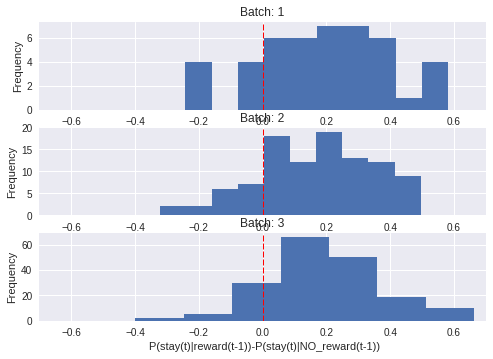

In [33]:
delta_p = {1:[], 2:[],3:[]} # count per batch

number_of_rewardewd_trials = {1:[], 2:[],3:[]} # count per batch
number_of_unrewardewd_trials = {1:[], 2:[],3:[]} # count per batch

for user in completed_users:
  rewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == REWARD]
  is_same_chioce_after_reward = [
      user['is_biased_choice'][reward_index]==
      user['is_biased_choice'][reward_index+1] 
      for reward_index in rewarded_trials_indices
      if reward_index < (len(user['is_biased_choice'])-2)]
  p_stay_after_reward = np.mean(is_same_chioce_after_reward)
  if not user['batch']:
    continue
  number_of_rewardewd_trials[user['batch']].append(len(is_same_chioce_after_reward))
  unrewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == NO_REWARD]
  is_same_chioce_after_NO_reward = [
      user['is_biased_choice'][un_reward_index]==
      user['is_biased_choice'][un_reward_index+1] 
      for un_reward_index in unrewarded_trials_indices
      if un_reward_index < (len(user['is_biased_choice'])-2)]
  p_stay_after_NO_reward = np.mean(is_same_chioce_after_NO_reward)
  number_of_unrewardewd_trials[user['batch']].append(len(is_same_chioce_after_NO_reward))
  
  user_delta_p = p_stay_after_reward - p_stay_after_NO_reward
  delta_p[user['batch']].append(user_delta_p)
  
# print('number_of_rewardewd_trials:', number_of_rewardewd_trials)
# print('number_of_unrewardewd_trials:', number_of_unrewardewd_trials)


for i in range(3):
  plt.subplot(310+i+1)
  plt.hist(delta_p[i+1], bins=10)
  plt.ylabel('Frequency')
  plt.xlabel(" P(stay(t)|reward(t-1))-P(stay(t)|NO_reward(t-1))")
  plt.axvline(x=0,linewidth=1, color='r', dashes=[6, 2])
  plt.title('Batch: ' + str(i+1))
  plt.xlim(-0.7,0.7)


##Bias distribution
For each subject, count the nubmer of choices in alternative 1.

For symetrical figure, the "anti-bias" is calculated.

Percentage of users for exclusion: 1.5345268542199488 %


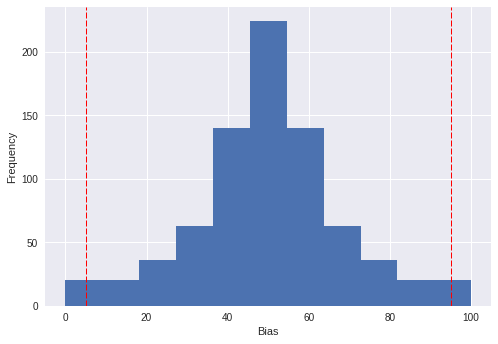

In [52]:
EXCLUSION_THRESHOLD = 95 # Not including this
biases = []
for user in completed_users:
  user_choices = [1 if bias==' true' else 0 for bias in user['is_biased_choice']]
  biases.append(sum(user_choices))

anti_bias =[100-bias for bias in biases]
# print(biases)
# print(anti_bias)

bias_and_anti = anti_bias.extend(biases)
plt.hist(anti_bias, bins = 11)
plt.ylabel('Frequency');
plt.xlabel("Bias");
plt.axvline(x=100-EXCLUSION_THRESHOLD,linewidth=1, color='r', dashes=[6, 2])
plt.axvline(x=EXCLUSION_THRESHOLD,linewidth=1, color='r', dashes=[6, 2])
print('Percentage of users for exclusion:', 100*np.mean([1 if bias>EXCLUSION_THRESHOLD else 0 for bias in biases]), '%')
